In [1]:
# %% [markdown]
# # Deforestation Chip Classifier - Component Testing
# 
# This notebook tests each component of the classifier pipeline individually.

# %% [markdown]
# ## Setup and Imports

# %%
import sys
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
import rootutils

root_path = rootutils.find_root()
sys.path.append(str(root_path))

from burned_embedder.classifier.dataset import DeforestationDataset, load_embedding_paths_and_labels, create_datasets
from burned_embedder.classifier.model import DifferenceMLP, get_model
from burned_embedder.classifier.model_utils import train_epoch, evaluate, EarlyStopping

print(f"Root path: {root_path}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Root path: /net/home/lmaecker/own_projects/burned_embedder
PyTorch version: 2.8.0+cu128
CUDA available: True


In [2]:
from burned_embedder.utils import setup_device

Testing embedding path loading...

Positive samples:
  Total: 761
  Labels (should all be 1): {1}
  First path example:
    Before: /net/home/lmaecker/own_projects/burned_embedder/data/processed/embeddings/positive/event_0/embedd_before.npy
    After:  /net/home/lmaecker/own_projects/burned_embedder/data/processed/embeddings/positive/event_0/embedd_after.npy

Negative samples:
  Total: 702
  Labels (should all be 0): {0}
  First path example:
    Before: /net/home/lmaecker/own_projects/burned_embedder/data/processed/embeddings/negative/event_0/embedd_before.npy
    After:  /net/home/lmaecker/own_projects/burned_embedder/data/processed/embeddings/negative/event_0/embedd_after.npy

Verifying first positive sample files exist:
  Before exists: True
  After exists:  True
Testing individual embedding loading...

Positive sample embeddings:
  Before shape: (768,)
  After shape:  (768,)
  Before stats: min=-2.2335, max=22.9595, mean=-0.0000
  After stats:  min=-2.1125, max=23.5525, mean=-0.00

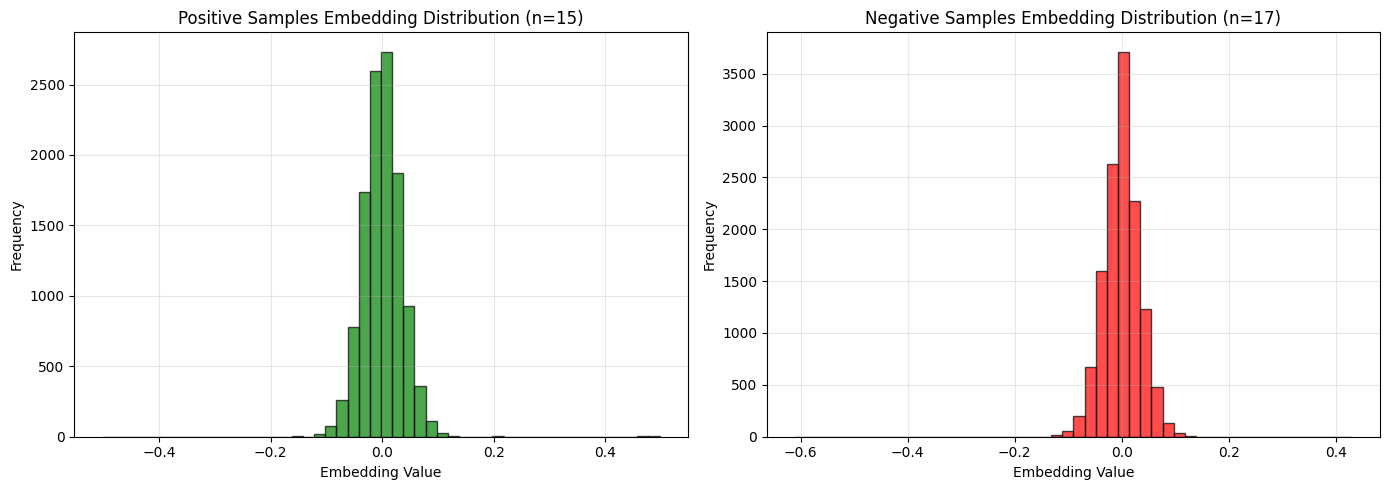


Positive embeddings stats:
  Mean: 0.0000
  Std:  0.0361
  Min:  -0.5019
  Max:  0.4971

Negative embeddings stats:
  Mean: -0.0000
  Std:  0.0350
  Min:  -0.6110
  Max:  0.4306
Testing model saving and loading...

✓ Model saved to /net/home/lmaecker/own_projects/burned_embedder/test_model.pt

Model Architecture:
DifferenceMLP(
  (model): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

Total parameters: 229,889
Trainable parameters: 229,889
✓ Model loaded from checkpoint
  Val F1 from checkpoint: 0.85

✓ Output difference between original and loaded model: 0.0000000000
  (should be ~0.0)

✓ Cleaned up test model file

COMPONENT TESTING SUMMARY
✓ All components tested successfully!

Tested components:
  1. 

In [ ]:


# %% [markdown]
# ## 1. Test Loading Embedding Paths

# %%
print("Testing embedding path loading...")
print("="*70)

# Load positive samples
pos_paths, pos_labels = load_embedding_paths_and_labels('positive')
print(f"\nPositive samples:")
print(f"  Total: {len(pos_paths)}")
print(f"  Labels (should all be 1): {set(pos_labels)}")
print(f"  First path example:")
print(f"    Before: {pos_paths[0][0]}")
print(f"    After:  {pos_paths[0][1]}")

# Load negative samples
neg_paths, neg_labels = load_embedding_paths_and_labels('negative')
print(f"\nNegative samples:")
print(f"  Total: {len(neg_paths)}")
print(f"  Labels (should all be 0): {set(neg_labels)}")
print(f"  First path example:")
print(f"    Before: {neg_paths[0][0]}")
print(f"    After:  {neg_paths[0][1]}")

# Check if files exist
print(f"\nVerifying first positive sample files exist:")
print(f"  Before exists: {pos_paths[0][0].exists()}")
print(f"  After exists:  {pos_paths[0][1].exists()}")

# %% [markdown]
# ## 2. Test Loading Individual Embeddings

# %%
print("Testing individual embedding loading...")
print("="*70)

# Load one positive sample
pos_before = np.load(pos_paths[0][0])
pos_after = np.load(pos_paths[0][1])

print(f"\nPositive sample embeddings:")
print(f"  Before shape: {pos_before.shape}")
print(f"  After shape:  {pos_after.shape}")
print(f"  Before stats: min={pos_before.min():.4f}, max={pos_before.max():.4f}, mean={pos_before.mean():.4f}")
print(f"  After stats:  min={pos_after.min():.4f}, max={pos_after.max():.4f}, mean={pos_after.mean():.4f}")

# Compute difference
pos_diff = pos_after - pos_before
print(f"\nDifference embedding:")
print(f"  Shape: {pos_diff.shape}")
print(f"  Stats: min={pos_diff.min():.4f}, max={pos_diff.max():.4f}, mean={pos_diff.mean():.4f}")
print(f"  L2 norm: {np.linalg.norm(pos_diff):.4f}")

# L2 normalize
pos_diff_norm = pos_diff / np.linalg.norm(pos_diff)
print(f"\nNormalized difference:")
print(f"  L2 norm (should be 1.0): {np.linalg.norm(pos_diff_norm):.4f}")

# Load one negative sample
neg_before = np.load(neg_paths[0][0])
neg_after = np.load(neg_paths[0][1])
neg_diff = neg_after - neg_before

print(f"\nNegative sample difference:")
print(f"  Stats: min={neg_diff.min():.4f}, max={neg_diff.max():.4f}, mean={neg_diff.mean():.4f}")
print(f"  L2 norm: {np.linalg.norm(neg_diff):.4f}")

# %% [markdown]
# ## 3. Test Dataset Class

# %%
print("Testing Dataset class...")
print("="*70)

# Create a small dataset with first 10 samples from each class
small_pos_paths = pos_paths[:10]
small_pos_labels = pos_labels[:10]
small_neg_paths = neg_paths[:10]
small_neg_labels = neg_labels[:10]

combined_paths = small_pos_paths + small_neg_paths
combined_labels = small_pos_labels + small_neg_labels

dataset = DeforestationDataset(combined_paths, combined_labels, normalize=True)

print(f"\nDataset created:")
print(f"  Total samples: {len(dataset)}")
print(f"  Positive samples: {sum(combined_labels)}")
print(f"  Negative samples: {len(combined_labels) - sum(combined_labels)}")

# Test __getitem__
print(f"\nTesting __getitem__:")
embedding, label = dataset[0]
print(f"  Sample 0 - Embedding shape: {embedding.shape}, Label: {label.item()}")
print(f"  Embedding type: {type(embedding)}, Label type: {type(label)}")
print(f"  Embedding dtype: {embedding.dtype}, Label dtype: {label.dtype}")
print(f"  Embedding L2 norm: {torch.norm(embedding).item():.4f}")

# Test a few more samples
for i in [5, 10, 15]:
    embedding, label = dataset[i]
    print(f"  Sample {i} - Shape: {embedding.shape}, Label: {label.item()}, Norm: {torch.norm(embedding).item():.4f}")

# %% [markdown]
# ## 4. Test Dataset Creation and Splits

# %%
print("Testing dataset creation with splits...")
print("="*70)

train_dataset, val_dataset, test_dataset = create_datasets(
    test_size=0.2,
    val_split=0.1,
    random_state=42
)

print(f"\nDataset statistics:")
print(f"  Train size: {len(train_dataset)}")
print(f"  Val size:   {len(val_dataset)}")
print(f"  Test size:  {len(test_dataset)}")
print(f"  Total:      {len(train_dataset) + len(val_dataset) + len(test_dataset)}")

# Check class balance in each split
def check_balance(dataset, name):
    labels = [int(dataset[i][1].item()) for i in range(len(dataset))]
    pos_count = sum(labels)
    neg_count = len(labels) - pos_count
    print(f"  {name:6s}: Pos={pos_count:4d} ({pos_count/len(labels)*100:.1f}%), Neg={neg_count:4d} ({neg_count/len(labels)*100:.1f}%)")
    
print(f"\nClass balance:")
check_balance(train_dataset, "Train")
check_balance(val_dataset, "Val")
check_balance(test_dataset, "Test")

# %% [markdown]
# ## 5. Test DataLoader

# %%
print("Testing DataLoader...")
print("="*70)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"\nDataLoader created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")

# Test one batch
embeddings, labels = next(iter(train_loader))
print(f"\nFirst batch:")
print(f"  Embeddings shape: {embeddings.shape}")
print(f"  Labels shape:     {labels.shape}")
print(f"  Labels in batch:  {labels.numpy()}")
print(f"  Positive count:   {(labels == 1).sum().item()}")
print(f"  Negative count:   {(labels == 0).sum().item()}")

# Check a few embedding norms
print(f"\nFirst 5 embedding L2 norms in batch:")
for i in range(min(5, len(embeddings))):
    print(f"  Sample {i}: {torch.norm(embeddings[i]).item():.4f}")

# %% [markdown]
# ## 6. Test Model Architecture

# %%
print("Testing model architecture...")
print("="*70)

# Get input dimension from dataset
sample_embedding, _ = train_dataset[0]
input_dim = sample_embedding.shape[0]

print(f"\nInput dimension: {input_dim}")

# Create model
device = setup_device(gpu_index=1, memory_fraction=1.0)
model = get_model(
    input_dim=input_dim,
    hidden_dims=[256, 128],
    dropout=0.4,
    device=device
)

# Test forward pass with single sample
model.eval()
with torch.no_grad():
    test_input = embeddings[0:1].to(device)
    output = model(test_input)
    print(f"\nSingle sample forward pass:")
    print(f"  Input shape:  {test_input.shape}")
    print(f"  Output shape: {output.shape}")
    print(f"  Output value: {output.item():.4f} (should be between 0 and 1)")

# Test forward pass with batch
with torch.no_grad():
    batch_output = model(embeddings.to(device))
    print(f"\nBatch forward pass:")
    print(f"  Input shape:  {embeddings.shape}")
    print(f"  Output shape: {batch_output.shape}")
    print(f"  Output range: [{batch_output.min().item():.4f}, {batch_output.max().item():.4f}]")
    print(f"  First 10 outputs: {batch_output[:10].cpu().numpy()}")

# %% [markdown]
# ## 7. Test Training Components

# %%
print("Testing training components...")
print("="*70)

# Setup
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Test one training epoch
print("\nRunning one training epoch...")
train_loss, train_f1, train_precision, train_recall = train_epoch(
    model, train_loader, criterion, optimizer, device
)

print(f"Training epoch results:")
print(f"  Loss:      {train_loss:.4f}")
print(f"  F1:        {train_f1:.4f}")
print(f"  Precision: {train_precision:.4f}")
print(f"  Recall:    {train_recall:.4f}")

# Test evaluation
print("\nRunning validation evaluation...")
val_loss, val_f1, val_precision, val_recall, val_auc, val_cm = evaluate(
    model, val_loader, criterion, device
)

print(f"Validation results:")
print(f"  Loss:      {val_loss:.4f}")
print(f"  F1:        {val_f1:.4f}")
print(f"  Precision: {val_precision:.4f}")
print(f"  Recall:    {val_recall:.4f}")
print(f"  ROC-AUC:   {val_auc:.4f}")
print(f"\nConfusion Matrix:")
print(f"              Predicted")
print(f"            Neg    Pos")
print(f"Actual Neg [{val_cm[0,0]:4d}  {val_cm[0,1]:4d}]")
print(f"       Pos [{val_cm[1,0]:4d}  {val_cm[1,1]:4d}]")

# %% [markdown]
# ## 8. Test Early Stopping

# %%
print("Testing early stopping...")
print("="*70)

early_stopping = EarlyStopping(patience=3, mode='max')

# Simulate improving scores
scores = [0.5, 0.6, 0.7, 0.75, 0.74, 0.73, 0.72, 0.71]

print("\nSimulating early stopping with scores:")
for epoch, score in enumerate(scores, 1):
    should_stop = early_stopping(score)
    status = "STOP" if should_stop else f"Continue (counter: {early_stopping.counter})"
    print(f"  Epoch {epoch}: Score={score:.2f}, Best={early_stopping.best_score:.2f} -> {status}")
    if should_stop:
        break

# %% [markdown]
# ## 9. Visualize Sample Embeddings

# %%
print("Visualizing embeddings...")
print("="*70)

# Get a batch of embeddings
embeddings_batch, labels_batch = next(iter(train_loader))

# Plot histogram of embedding values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Positive samples
pos_mask = labels_batch == 1
pos_embeddings = embeddings_batch[pos_mask].numpy().flatten()

axes[0].hist(pos_embeddings, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0].set_title(f'Positive Samples Embedding Distribution (n={pos_mask.sum()})')
axes[0].set_xlabel('Embedding Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Negative samples
neg_mask = labels_batch == 0
neg_embeddings = embeddings_batch[neg_mask].numpy().flatten()

axes[1].hist(neg_embeddings, bins=50, alpha=0.7, color='red', edgecolor='black')
axes[1].set_title(f'Negative Samples Embedding Distribution (n={neg_mask.sum()})')
axes[1].set_xlabel('Embedding Value')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPositive embeddings stats:")
print(f"  Mean: {pos_embeddings.mean():.4f}")
print(f"  Std:  {pos_embeddings.std():.4f}")
print(f"  Min:  {pos_embeddings.min():.4f}")
print(f"  Max:  {pos_embeddings.max():.4f}")

print(f"\nNegative embeddings stats:")
print(f"  Mean: {neg_embeddings.mean():.4f}")
print(f"  Std:  {neg_embeddings.std():.4f}")
print(f"  Min:  {neg_embeddings.min():.4f}")
print(f"  Max:  {neg_embeddings.max():.4f}")

# %% [markdown]
# ## 10. Test Model Saving and Loading

# %%
print("Testing model saving and loading...")
print("="*70)

# Save model
save_path = root_path /"model" "test_model.pt"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'input_dim': input_dim,
    'val_f1': 0.85
}, save_path)

print(f"\n✓ Model saved to {save_path}")

# Create new model and load weights
new_model = get_model(input_dim=input_dim, hidden_dims=[256, 128], dropout=0.4, device=device)
checkpoint = torch.load(save_path)
new_model.load_state_dict(checkpoint['model_state_dict'])

print(f"✓ Model loaded from checkpoint")
print(f"  Val F1 from checkpoint: {checkpoint['val_f1']:.2f}")

# Verify models produce same output
model.eval()
new_model.eval()
with torch.no_grad():
    test_input = embeddings[0:5].to(device)
    output1 = model(test_input)
    output2 = new_model(test_input)
    diff = torch.abs(output1 - output2).max().item()
    print(f"\n✓ Output difference between original and loaded model: {diff:.10f}")
    print(f"  (should be ~0.0)")

# Clean up
save_path.unlink()
print(f"\n✓ Cleaned up test model file")

# %% [markdown]
# ## Summary

# %%
print("\n" + "="*70)
print("COMPONENT TESTING SUMMARY")
print("="*70)
print("✓ All components tested successfully!")
print("\nTested components:")
print("  1. Embedding path loading")
print("  2. Individual embedding loading and difference computation")
print("  3. Dataset class")
print("  4. Dataset splits (train/val/test)")
print("  5. DataLoader batching")
print("  6. Model architecture and forward pass")
print("  7. Training and evaluation functions")
print("  8. Early stopping")
print("  9. Embedding visualization")
print("  10. Model saving and loading")
print("\n✓ Ready to run full training with scripts/train_chip_classifier.py")

# %%

Loading most recent summary: summary_20250929_133253.json

EXPERIMENT RESULTS SUMMARY

Rank  Experiment                    F1      Prec    Recall  AUC     Overfit   
----------------------------------------------------------------------------------------------------
1     exp_concat                    0.8125  0.7738  0.8553  0.8853  0.0816    
2     exp_combined                  0.8025  0.7665  0.8421  0.8642  0.1625    
3     exp_concat_regularized        0.7938  0.7457  0.8487  0.8463  -0.0066   
4     exp_medium                    0.7908  0.7857  0.7961  0.8367  0.1848    
5     exp_deep                      0.7881  0.7933  0.7829  0.8315  0.1876    
6     exp_weight_decay_strong       0.7800  0.7905  0.7697  0.8424  0.1428    
7     exp_regularized               0.7762  0.8284  0.7303  0.8400  0.0597    
8     exp_batch_small               0.7759  0.7891  0.7632  0.8355  0.1881    
9     exp_weight_decay              0.7713  0.8014  0.7434  0.8279  0.1639    
10    baseline        

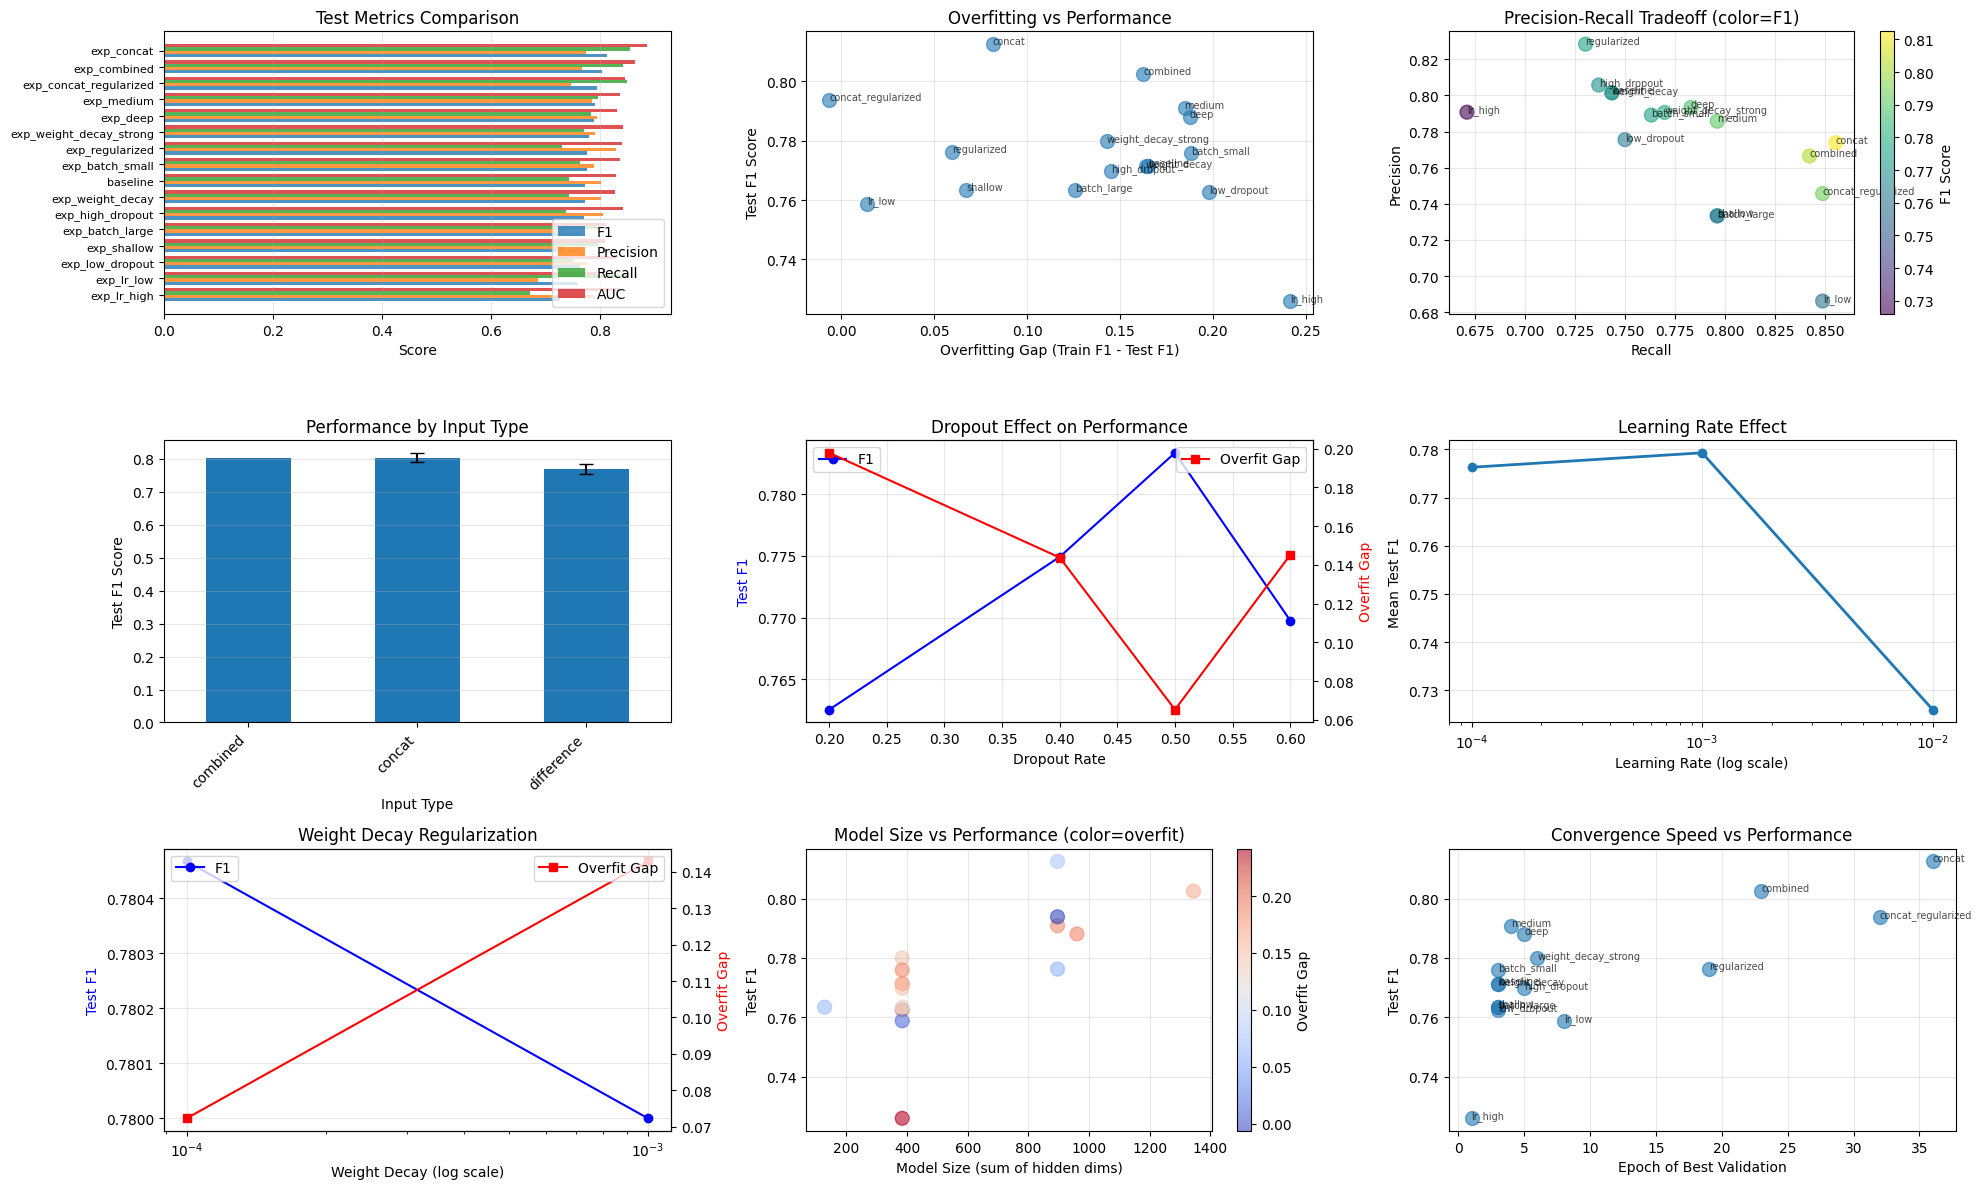

Confusion matrices saved to /net/home/lmaecker/own_projects/burned_embedder/experiments/confusion_matrices_summary_20250929_133253.png


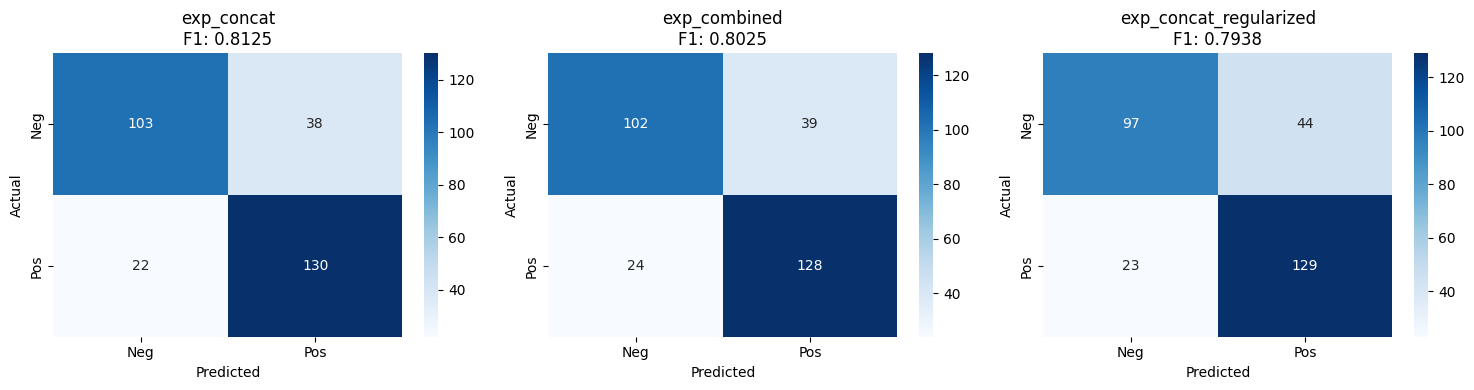


Analysis complete!


In [4]:
# scripts/analyze_experiments.py

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import rootutils

root_path = rootutils.find_root()

def load_experiment_results(summary_file=None):
    """Load experiment results from JSON file"""
    experiments_dir = root_path / "experiments"
    
    if summary_file is None:
        # Find the most recent summary file
        summary_files = sorted(experiments_dir.glob("summary_*.json"))
        if not summary_files:
            raise FileNotFoundError("No summary files found in experiments directory")
        summary_file = summary_files[-1]
        print(f"Loading most recent summary: {summary_file.name}")
    else:
        summary_file = Path(summary_file)
    
    with open(summary_file, 'r') as f:
        results = json.load(f)
    
    return results, summary_file


def results_to_dataframe(results):
    """Convert results list to pandas DataFrame"""
    if not results:
        raise ValueError("No results to analyze - all experiments failed")
    
    data = []
    for result in results:
        row = {
            'experiment': result['experiment_name'],
            'test_f1': result['test_f1'],
            'test_precision': result['test_precision'],
            'test_recall': result['test_recall'],
            'test_auc': result['test_roc_auc'],
            'val_f1': result['best_val_f1'],
            'overfit_gap': result['overfit_gap'],
            'best_epoch': result['best_epoch'],
            'input_type': result['config']['input_type'],
            'hidden_dims': str(result['config']['hidden_dims']),
            'dropout': result['config']['dropout'],
            'lr': result['config']['lr'],
            'weight_decay': result['config']['weight_decay'],
            'batch_size': result['config']['batch_size'],
        }
        data.append(row)
    
    df = pd.DataFrame(data)
    return df


def print_summary_table(df):
    """Print formatted summary table"""
    print("\n" + "="*100)
    print("EXPERIMENT RESULTS SUMMARY")
    print("="*100)
    
    # Sort by test F1
    df_sorted = df.sort_values('test_f1', ascending=False)
    
    print(f"\n{'Rank':<6}{'Experiment':<30}{'F1':<8}{'Prec':<8}{'Recall':<8}{'AUC':<8}{'Overfit':<10}")
    print("-"*100)
    
    for idx, (_, row) in enumerate(df_sorted.iterrows(), 1):
        print(f"{idx:<6}{row['experiment']:<30}{row['test_f1']:<8.4f}{row['test_precision']:<8.4f}"
              f"{row['test_recall']:<8.4f}{row['test_auc']:<8.4f}{row['overfit_gap']:<10.4f}")
    
    # Print best models by different metrics
    print(f"\n" + "="*100)
    print("BEST MODELS BY METRIC")
    print("="*100)
    
    print(f"\nBest F1 Score:      {df_sorted.iloc[0]['experiment']:<30} (F1: {df_sorted.iloc[0]['test_f1']:.4f})")
    print(f"Best Precision:     {df.loc[df['test_precision'].idxmax(), 'experiment']:<30} "
          f"(Prec: {df['test_precision'].max():.4f})")
    print(f"Best Recall:        {df.loc[df['test_recall'].idxmax(), 'experiment']:<30} "
          f"(Recall: {df['test_recall'].max():.4f})")
    print(f"Best AUC:           {df.loc[df['test_auc'].idxmax(), 'experiment']:<30} "
          f"(AUC: {df['test_auc'].max():.4f})")
    print(f"Least Overfit:      {df.loc[df['overfit_gap'].idxmin(), 'experiment']:<30} "
          f"(Gap: {df['overfit_gap'].min():.4f})")


def analyze_by_category(df):
    """Analyze results by different configuration categories"""
    print(f"\n" + "="*100)
    print("ANALYSIS BY CONFIGURATION")
    print("="*100)
    
    # By input type
    print("\n1. By Input Type:")
    input_analysis = df.groupby('input_type').agg({
        'test_f1': ['mean', 'std', 'max'],
        'overfit_gap': 'mean'
    }).round(4)
    print(input_analysis)
    
    # By dropout
    print("\n2. By Dropout Rate:")
    dropout_analysis = df.groupby('dropout').agg({
        'test_f1': ['mean', 'std', 'max'],
        'overfit_gap': 'mean'
    }).round(4)
    print(dropout_analysis)
    
    # By learning rate
    print("\n3. By Learning Rate:")
    lr_analysis = df.groupby('lr').agg({
        'test_f1': ['mean', 'std', 'max'],
        'overfit_gap': 'mean'
    }).round(4)
    print(lr_analysis)
    
    # By weight decay
    print("\n4. By Weight Decay:")
    wd_analysis = df.groupby('weight_decay').agg({
        'test_f1': ['mean', 'std', 'max'],
        'overfit_gap': 'mean'
    }).round(4)
    print(wd_analysis)


def plot_experiment_comparison(df, save_path=None):
    """Create comprehensive visualization of experiment results"""
    fig = plt.figure(figsize=(20, 12))
    
    # Sort by F1 score
    df_sorted = df.sort_values('test_f1', ascending=True)
    
    # 1. Main metrics comparison (bar chart)
    ax1 = plt.subplot(3, 3, 1)
    x = np.arange(len(df_sorted))
    width = 0.2
    
    ax1.barh(x - width*1.5, df_sorted['test_f1'], width, label='F1', alpha=0.8)
    ax1.barh(x - width*0.5, df_sorted['test_precision'], width, label='Precision', alpha=0.8)
    ax1.barh(x + width*0.5, df_sorted['test_recall'], width, label='Recall', alpha=0.8)
    ax1.barh(x + width*1.5, df_sorted['test_auc'], width, label='AUC', alpha=0.8)
    
    ax1.set_yticks(x)
    ax1.set_yticklabels(df_sorted['experiment'], fontsize=8)
    ax1.set_xlabel('Score')
    ax1.set_title('Test Metrics Comparison')
    ax1.legend()
    ax1.grid(axis='x', alpha=0.3)
    
    # 2. Overfitting analysis
    ax2 = plt.subplot(3, 3, 2)
    ax2.scatter(df['overfit_gap'], df['test_f1'], s=100, alpha=0.6)
    for idx, row in df.iterrows():
        ax2.annotate(row['experiment'].replace('exp_', ''), 
                     (row['overfit_gap'], row['test_f1']), 
                     fontsize=7, alpha=0.7)
    ax2.set_xlabel('Overfitting Gap (Train F1 - Test F1)')
    ax2.set_ylabel('Test F1 Score')
    ax2.set_title('Overfitting vs Performance')
    ax2.grid(alpha=0.3)
    
    # 3. Precision-Recall tradeoff
    ax3 = plt.subplot(3, 3, 3)
    ax3.scatter(df['test_recall'], df['test_precision'], s=100, alpha=0.6, c=df['test_f1'], 
                cmap='viridis')
    for idx, row in df.iterrows():
        ax3.annotate(row['experiment'].replace('exp_', ''), 
                     (row['test_recall'], row['test_precision']), 
                     fontsize=7, alpha=0.7)
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_title('Precision-Recall Tradeoff (color=F1)')
    ax3.grid(alpha=0.3)
    plt.colorbar(ax3.collections[0], ax=ax3, label='F1 Score')
    
    # 4. Input type comparison
    ax4 = plt.subplot(3, 3, 4)
    input_data = df.groupby('input_type')['test_f1'].agg(['mean', 'std'])
    input_data['mean'].plot(kind='bar', yerr=input_data['std'], ax=ax4, capsize=5)
    ax4.set_xlabel('Input Type')
    ax4.set_ylabel('Test F1 Score')
    ax4.set_title('Performance by Input Type')
    ax4.grid(axis='y', alpha=0.3)
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 5. Dropout effect
    ax5 = plt.subplot(3, 3, 5)
    dropout_df = df.groupby('dropout').agg({'test_f1': 'mean', 'overfit_gap': 'mean'})
    ax5_twin = ax5.twinx()
    dropout_df['test_f1'].plot(ax=ax5, marker='o', color='blue', label='F1')
    dropout_df['overfit_gap'].plot(ax=ax5_twin, marker='s', color='red', label='Overfit Gap')
    ax5.set_xlabel('Dropout Rate')
    ax5.set_ylabel('Test F1', color='blue')
    ax5_twin.set_ylabel('Overfit Gap', color='red')
    ax5.set_title('Dropout Effect on Performance')
    ax5.grid(alpha=0.3)
    ax5.legend(loc='upper left')
    ax5_twin.legend(loc='upper right')
    
    # 6. Learning rate effect
    ax6 = plt.subplot(3, 3, 6)
    lr_df = df.groupby('lr')['test_f1'].mean()
    ax6.plot(lr_df.index, lr_df.values, marker='o', linewidth=2)
    ax6.set_xscale('log')
    ax6.set_xlabel('Learning Rate (log scale)')
    ax6.set_ylabel('Mean Test F1')
    ax6.set_title('Learning Rate Effect')
    ax6.grid(alpha=0.3)
    
    # 7. Weight decay effect
    ax7 = plt.subplot(3, 3, 7)
    wd_df = df[df['weight_decay'] > 0].groupby('weight_decay').agg({'test_f1': 'mean', 'overfit_gap': 'mean'})
    if len(wd_df) > 0:
        ax7_twin = ax7.twinx()
        wd_df['test_f1'].plot(ax=ax7, marker='o', color='blue', label='F1')
        wd_df['overfit_gap'].plot(ax=ax7_twin, marker='s', color='red', label='Overfit Gap')
        ax7.set_xscale('log')
        ax7.set_xlabel('Weight Decay (log scale)')
        ax7.set_ylabel('Test F1', color='blue')
        ax7_twin.set_ylabel('Overfit Gap', color='red')
        ax7.set_title('Weight Decay Regularization')
        ax7.grid(alpha=0.3)
        ax7.legend(loc='upper left')
        ax7_twin.legend(loc='upper right')
    
    # 8. Model size analysis (count parameters)
    ax8 = plt.subplot(3, 3, 8)
    # Extract total layer sizes as proxy for model size
    df['model_size'] = df['hidden_dims'].apply(lambda x: sum(eval(x)))
    ax8.scatter(df['model_size'], df['test_f1'], s=100, alpha=0.6, c=df['overfit_gap'], 
                cmap='coolwarm')
    ax8.set_xlabel('Model Size (sum of hidden dims)')
    ax8.set_ylabel('Test F1')
    ax8.set_title('Model Size vs Performance (color=overfit)')
    ax8.grid(alpha=0.3)
    plt.colorbar(ax8.collections[0], ax=ax8, label='Overfit Gap')
    
    # 9. Training convergence (epochs to best)
    ax9 = plt.subplot(3, 3, 9)
    ax9.scatter(df['best_epoch'], df['test_f1'], s=100, alpha=0.6)
    for idx, row in df.iterrows():
        ax9.annotate(row['experiment'].replace('exp_', ''), 
                     (row['best_epoch'], row['test_f1']), 
                     fontsize=7, alpha=0.7)
    ax9.set_xlabel('Epoch of Best Validation')
    ax9.set_ylabel('Test F1')
    ax9.set_title('Convergence Speed vs Performance')
    ax9.grid(alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nVisualization saved to {save_path}")
    
    plt.show()


def plot_top_models_confusion(results, top_n=3, save_path=None):
    """Plot confusion matrices for top N models"""
    # Sort by F1 score
    sorted_results = sorted(results, key=lambda x: x['test_f1'], reverse=True)
    top_results = sorted_results[:top_n]
    
    fig, axes = plt.subplots(1, top_n, figsize=(5*top_n, 4))
    if top_n == 1:
        axes = [axes]
    
    for idx, result in enumerate(top_results):
        cm = np.array(result['confusion_matrix'])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
        
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
        axes[idx].set_title(f"{result['experiment_name']}\nF1: {result['test_f1']:.4f}")
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrices saved to {save_path}")
    
    plt.show()


def generate_recommendations(df):
    """Generate recommendations based on experiment results"""
    print(f"\n" + "="*100)
    print("RECOMMENDATIONS")
    print("="*100)
    
    best_overall = df.loc[df['test_f1'].idxmax()]
    least_overfit = df.loc[df['overfit_gap'].idxmin()]
    best_recall = df.loc[df['test_recall'].idxmax()]
    best_precision = df.loc[df['test_precision'].idxmax()]
    
    print(f"\n1. Best Overall Performance:")
    print(f"   Model: {best_overall['experiment']}")
    print(f"   Configuration: input={best_overall['input_type']}, dropout={best_overall['dropout']}, "
          f"lr={best_overall['lr']}, wd={best_overall['weight_decay']}")
    print(f"   Metrics: F1={best_overall['test_f1']:.4f}, Prec={best_overall['test_precision']:.4f}, "
          f"Rec={best_overall['test_recall']:.4f}")
    
    print(f"\n2. Most Generalizable (least overfitting):")
    print(f"   Model: {least_overfit['experiment']}")
    print(f"   Overfit gap: {least_overfit['overfit_gap']:.4f}")
    print(f"   Test F1: {least_overfit['test_f1']:.4f}")
    
    print(f"\n3. Best for Minimizing False Negatives (high recall):")
    print(f"   Model: {best_recall['experiment']}")
    print(f"   Recall: {best_recall['test_recall']:.4f} (catches {best_recall['test_recall']*100:.1f}% of deforestation)")
    
    print(f"\n4. Best for Minimizing False Positives (high precision):")
    print(f"   Model: {best_precision['experiment']}")
    print(f"   Precision: {best_precision['test_precision']:.4f} ({best_precision['test_precision']*100:.1f}% of predictions are correct)")
    
    # General insights
    print(f"\n5. Key Insights:")
    
    # Input type
    best_input = df.groupby('input_type')['test_f1'].mean().idxmax()
    print(f"   - Best input representation: {best_input}")
    
    # Regularization
    if df['overfit_gap'].mean() > 0.1:
        print(f"   - Strong overfitting detected (avg gap: {df['overfit_gap'].mean():.3f})")
        print(f"     → Consider: higher dropout, weight decay, or simpler models")
    
    # Dropout sweet spot
    if len(df['dropout'].unique()) > 1:
        dropout_perf = df.groupby('dropout')['test_f1'].mean()
        best_dropout = dropout_perf.idxmax()
        print(f"   - Optimal dropout rate appears to be: {best_dropout}")


def main():
    """Main analysis function"""
    # Load results
    results, summary_file = load_experiment_results()
    
    if not results:
        print("No experiment results found or all experiments failed!")
        return
    
    # Convert to DataFrame
    df = results_to_dataframe(results)
    
    # Print summary table
    print_summary_table(df)
    
    # Analyze by category
    analyze_by_category(df)
    
    # Generate recommendations
    generate_recommendations(df)
    
    # Create visualizations
    viz_path = root_path / "experiments" / f"analysis_{summary_file.stem}.png"
    plot_experiment_comparison(df, save_path=viz_path)
    
    # Plot confusion matrices for top 3
    cm_path = root_path / "experiments" / f"confusion_matrices_{summary_file.stem}.png"
    plot_top_models_confusion(results, top_n=3, save_path=cm_path)
    
    print(f"\n{'='*100}")
    print("Analysis complete!")
    print(f"{'='*100}")


if __name__ == "__main__":
    main()